## Preprocessing the data

In [1]:
import pandas as pd
import holidays
import statsmodels.api as sm
import matplotlib.pyplot as plt
#import seaborn as sns
import pytz
from statsmodels.tsa.seasonal import STL
from darts import TimeSeries
from darts.metrics import mape, rmse, mae


# Create a DataFrame from Load source
load2023 = pd.read_csv("Load_Data/Total Load - Day Ahead _ Actual_2023.csv", delimiter=",")
load2024 = pd.read_csv("Load_Data/Total Load - Day Ahead _ Actual_2024.csv", delimiter=",")
load_df = pd.concat([load2023, load2024], ignore_index=True)

# Read temperature data (downlaoded from SMHI)
weather_data = pd.read_csv("Temperature Data/smhi-opendata_1_98230_202301_202412.csv", delimiter=";", skiprows=9)

# Process load data by changing column name
load_df['Time (UTC)'] = load_df['Time (UTC)'].str.split(' - ').str[0]
load_df = load_df.rename(columns={'Time (UTC)': 'completetime', 'Actual Total Load [MW] - BZN|SE3': 'Load'})
load_df['datetime'] = pd.to_datetime(load_df['completetime'], format='%d.%m.%Y %H:%M')
load_df = load_df.drop(['completetime'], axis=1)

# Create datetime in weather_data
date_col = 'Datum'  
time_col = 'Tid (UTC)'  

# Create datetime column in weather_data by combining date and time
weather_data['datetime'] = pd.to_datetime(
    weather_data[date_col].astype(str) + ' ' + weather_data[time_col].astype(str)
)

# Create a temporary dataframe with just datetime and temperature
temp_df = weather_data[['datetime', 'Lufttemperatur']].copy()
temp_df.rename(columns={'Lufttemperatur': 'Temperature'}, inplace=True)


# Remove any duplicates in temperature data (checking by datetime)
if temp_df['datetime'].duplicated().any():
    print(f"Found {temp_df['datetime'].duplicated().sum()} duplicate timestamps in temperature data Stockholm")
    temp_df = temp_df.drop_duplicates(subset=['datetime'])

# Merge the dataframes based on datetime
print(f"Load data shape before merge: {load_df.shape}")
load_df = load_df.merge(temp_df, on='datetime', how='left')
print(f"Load data shape after merge: {load_df.shape}")

# Check for missing temperature values and identify where they are
missing_temp = load_df['Temperature'].isna().sum()
print(f"\nMissing temperature values after merge: {missing_temp}")

# Check the temprature missing data and doing interpolation
if missing_temp > 0:
    # Find rows with missing temperature values
    missing_rows = load_df[load_df['Temperature'].isna()]
    
    # Display information about the missing data
    print("\nRows with missing temperature values:")
    print(f"Total missing values: {len(missing_rows)}")
    
    # Show the first few rows with missing values
    print("\nFirst 10 rows with missing temperature values:")
    print(missing_rows[['datetime', 'Load']].head(10))
    
    # Show the distribution of missing values by month and hour
    print("\nMissing values by month:")
    print(missing_rows['datetime'].dt.month.value_counts().sort_index())
    
    print("\nMissing values by hour of day:")
    print(missing_rows['datetime'].dt.hour.value_counts().sort_index())
    
    # Check if missing values are consecutive
    missing_rows_sorted = missing_rows.sort_values('datetime')
    time_diff = missing_rows_sorted['datetime'].diff()
    
    print("\nTime differences between consecutive missing values (first 10):")
    print(time_diff.head(10))
    
    # Identify gaps in temperature data
    common_diff = time_diff.mode()[0]
    print(f"Most common time difference between missing values: {common_diff}")
    
    # Set datetime as index for time-based interpolation
    load_df_temp = load_df.set_index('datetime')
    
    # Perform interpolation
    load_df_temp['Temperature'] = load_df_temp['Temperature'].interpolate(method='time')
    
    # Handle any remaining missing values
    load_df_temp['Temperature'] = load_df_temp['Temperature'].fillna(method='ffill').fillna(method='bfill')
    
    # Reset index
    load_df = load_df_temp.reset_index()
    
    print(f"\nRemaining missing values after interpolation: {load_df['Temperature'].isna().sum()}")

# Adding day type (Month, Week and hour of the day)
load_df['Month'] = load_df['datetime'].dt.month
load_df['Day_of_week'] = load_df['datetime'].dt.dayofweek
load_df['Hour_of_day'] = load_df['datetime'].dt.hour

# change column name
load_df['entso-e_forecast']=load_df['Day-ahead Total Load Forecast [MW] - BZN|SE3']

# Adding Holidays 
Sweden_holidays = holidays.CountryHoliday('SE')
load_df['Holidays'] = [int((date in Sweden_holidays) and date.weekday() != 6) for date in load_df.datetime]

# Create Daylight Saving Column covariates
# Define Sweden timezone
sweden_tz = pytz.timezone('Europe/Stockholm')

def is_dst_sweden(naive_dt):
    try:
        # First, assume the naive datetime is in UTC
        utc_dt = pd.Timestamp(naive_dt).tz_localize('UTC')
        # Then convert UTC time to Sweden time
        sweden_time = utc_dt.astimezone(sweden_tz)
        # Return 1 if DST is active, 0 if not
        return int(sweden_time.dst() != pd.Timedelta(0))
    except Exception as e:
        print(f"Error processing {naive_dt}: {e}")
        return None

# Apply the function to get DST status (1 or 0)
load_df['DST'] = load_df['datetime'].apply(is_dst_sweden)

# Reorder columns
load_df = load_df[['datetime', 'entso-e_forecast','Load', 'Temperature', 'Month','Day_of_week', 'Hour_of_day', 'Holidays','DST']]

# Display a sample of the final dataframe
print("\nFinal dataframe sample:")
print(load_df.head())

# Convert the panda data frame into DART dataseries
Load = TimeSeries.from_dataframe(
    df=load_df,
    time_col="datetime",
    value_cols=["Load"]
)

Temp = TimeSeries.from_dataframe(
    df=load_df,
    time_col="datetime",
    value_cols=["Temperature"]
)

Holidays = TimeSeries.from_dataframe(
    df=load_df,
    time_col="datetime",
    value_cols=["Holidays"]
)

load_df

Load data shape before merge: (17544, 3)
Load data shape after merge: (17544, 4)

Missing temperature values after merge: 9

Rows with missing temperature values:
Total missing values: 9

First 10 rows with missing temperature values:
                 datetime   Load
6800  2023-10-11 08:00:00   9888
6801  2023-10-11 09:00:00   9850
6802  2023-10-11 10:00:00   9679
6803  2023-10-11 11:00:00   9544
6805  2023-10-11 13:00:00   9245
6943  2023-10-17 07:00:00  10537
6944  2023-10-17 08:00:00  10341
14983 2024-09-16 07:00:00   9398
14984 2024-09-16 08:00:00   9359

Missing values by month:
datetime
9     2
10    7
Name: count, dtype: int64

Missing values by hour of day:
datetime
7     2
8     3
9     1
10    1
11    1
13    1
Name: count, dtype: int64

Time differences between consecutive missing values (first 10):
6800                  NaT
6801      0 days 01:00:00
6802      0 days 01:00:00
6803      0 days 01:00:00
6805      0 days 02:00:00
6943      5 days 18:00:00
6944      0 days 01:00

C:\Users\jakfa\AppData\Local\Temp\ipykernel_23048\3308423576.py:92: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  load_df_temp['Temperature'] = load_df_temp['Temperature'].fillna(method='ffill').fillna(method='bfill')



Final dataframe sample:
             datetime  entso-e_forecast  Load  Temperature  Month  \
0 2023-01-01 00:00:00              8897  8943          3.6      1   
1 2023-01-01 01:00:00              8836  8929          3.0      1   
2 2023-01-01 02:00:00              8779  8887          2.6      1   
3 2023-01-01 03:00:00              8806  8859          2.4      1   
4 2023-01-01 04:00:00              8958  8880          2.0      1   

   Day_of_week  Hour_of_day  Holidays  DST  
0            6            0         0    0  
1            6            1         0    0  
2            6            2         0    0  
3            6            3         0    0  
4            6            4         0    0  


,datetime,entso-e_forecast,Load,Temperature,Month,Day_of_week,Hour_of_day,Holidays,DST
0,2023-01-01 00:00:00,8897,8943,3.6,1,6,0,0,0
1,2023-01-01 01:00:00,8836,8929,3.0,1,6,1,0,0
2,2023-01-01 02:00:00,8779,8887,2.6,1,6,2,0,0
3,2023-01-01 03:00:00,8806,8859,2.4,1,6,3,0,0
4,2023-01-01 04:00:00,8958,8880,2.0,1,6,4,0,0
...,...,...,...,...,...,...,...,...,...
17539,2024-12-31 19:00:00,10929,11092,-2.1,12,1,19,1,0
17540,2024-12-31 20:00:00,10568,10798,-1.8,12,1,20,1,0
17541,2024-12-31 21:00:00,10272,10531,-3.0,12,1,21,1,0
17542,2024-12-31 22:00:00,9981,10165,-2.7,12,1,22,1,0


Design graph for report

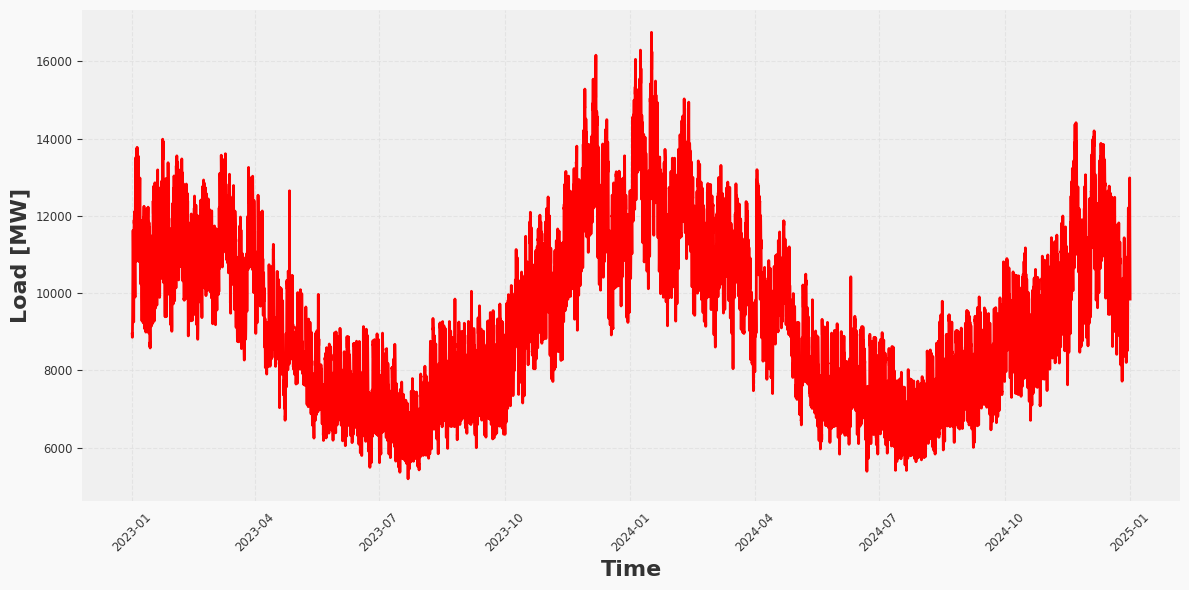

In [2]:

import matplotlib.dates as mdates

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot with datetime on x-axis and load on y-axis
ax.plot(load_df['datetime'], load_df['Load'], color='red', linewidth=2)

# Set background color
ax.set_facecolor('#f0f0f0')  # Light gray background
fig.set_facecolor('#f9f9f9')  # Slightly lighter gray for figure background

# Format the x-axis to show datetime properly
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

# Add labels
plt.xlabel('Time',fontsize=16)
plt.ylabel('Load [MW]',fontsize=16)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()  # This ensures the rotated x-labels fit properly

plt.show()

### Check Outlier

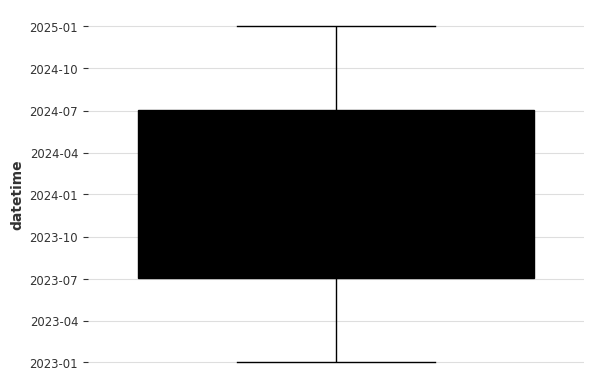

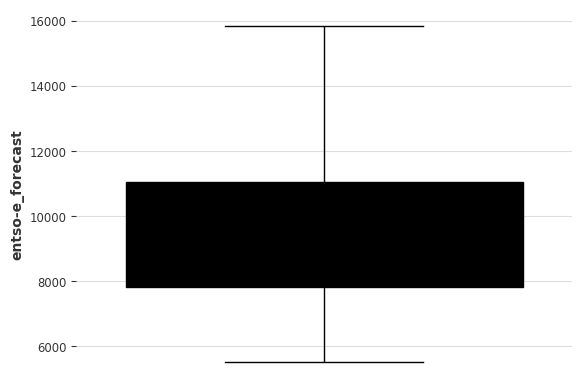

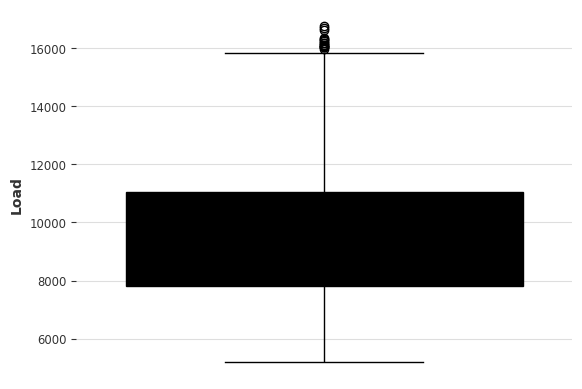

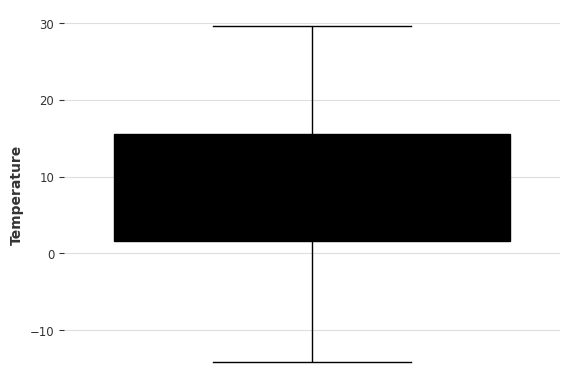

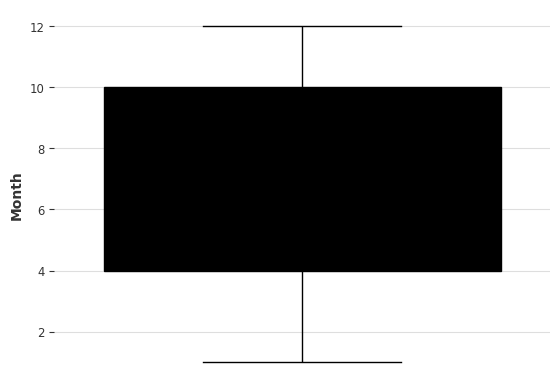

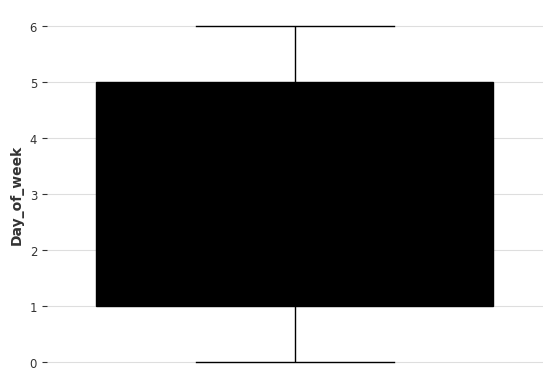

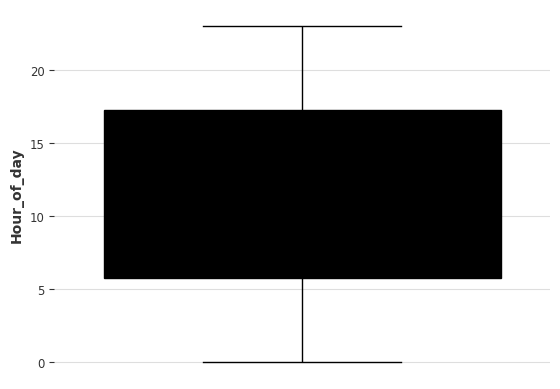

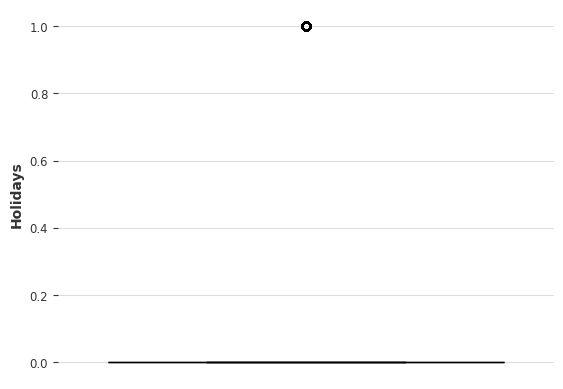

In [4]:
# To find outliers
cols = load_df.columns[0:-1]
for i in cols:
    sns.boxplot(y=load_df[i])
    plt.show()

## Set Training and Test Data

In [16]:
# Split 80% Load Data for training and 20% for testing
total_samples = len(Load)
split_point = int(total_samples * 0.8)

# Assuming the Load class has an iloc-like method or can take indices
load_train = Load[:split_point]
load_test = Load[split_point:]



## Create Evaluation Function
Show the grap of forecast vs Actual and use MAPE,MAE and RMSE
1. eval_model function (normal) for calculate the error
2. eval_model_transform (for machine learning/RNN since it need transform data scaling (0-1) back to normal MW again) 

In [41]:
def eval_model(model, past_covariates=None, future_covariates=None, to_retrain=True):
    
    backtest = model.historical_forecasts(series=Load, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=pd.to_datetime('2024-09-01'), 
                                          retrain=to_retrain,
                                          verbose=False, 
                                          forecast_horizon=24,)
    
    Load[-len(backtest)-168:].plot()
    backtest.plot(label='Backtest')
    print('Backtest MAPE = {}'.format(mape(Load, backtest)))
    print('Backtest MAE = {}'.format(mae(Load,backtest)))
    print('Backtest RMSE = {}'.format(rmse(Load,backtest)))
    plt.show()

    error = Load[-len(backtest):].to_series() - backtest.to_series()
    error.rolling(49, center=True).mean().plot()
    plt.show()

In [34]:
def eval_model_transform(model, past_covariates=None, future_covariates=None, to_retrain=True):
    
    backtest = model.historical_forecasts(series=Load_transformed, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=pd.to_datetime('2024-09-01'), 
                                          retrain=to_retrain,
                                          verbose=False, 
                                          forecast_horizon=24)
    
    # Inverse-transform predictions to original scale
    backtest_scaled = transformer.inverse_transform(backtest)

    Load[-len(backtest)-168:].plot()
    backtest_scaled.plot(label='Backtest')
    print('Backtest MAPE = {}'.format(mape(Load, backtest_scaled)))
    print('Backtest MAE = {}'.format(mae(Load, backtest_scaled)))
    print('Backtest RMSE = {}'.format(rmse(Load, backtest_scaled)))
    plt.show()

    error = Load[-len(backtest_scaled):].to_series() - backtest_scaled.to_series()
    error.rolling(49, center=True).mean().plot()
    plt.show()

## Eval the forecast from entso-E

Backtest MAPE = 2.540147007186436
Backtest MAE = 238.06007751937983
Backtest RMSE = 310.1461112945271


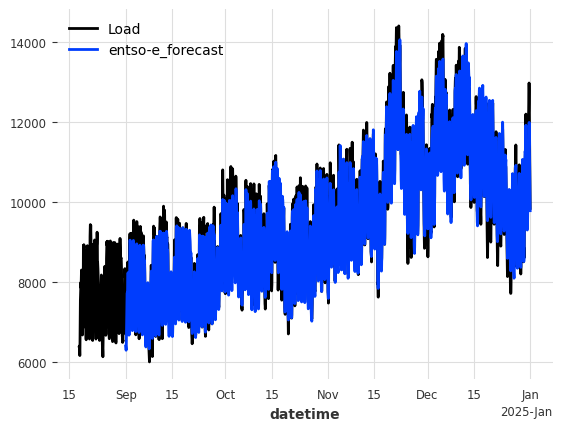

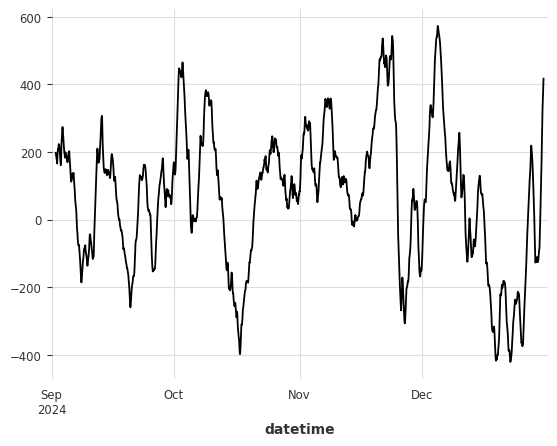

In [39]:
entsoe_forecast = TimeSeries.from_dataframe(
    df=load_df,
    time_col="datetime",
    value_cols=["entso-e_forecast"]
)

start_date = pd.Timestamp("2024-09-01")
filtered_df = load_df[load_df["datetime"] >= start_date]


Load[-len(filtered_df)-336:].plot()
entsoe_forecast[-len(filtered_df):].plot()
print('Backtest MAPE = {}'.format(mape(Load,entsoe_forecast)))
print('Backtest MAE = {}'.format(mae(Load,entsoe_forecast)))
print('Backtest RMSE = {}'.format(rmse(Load,entsoe_forecast)))

plt.show()

error = Load[-len(filtered_df):].to_series() - entsoe_forecast[-len(filtered_df):].to_series()
error.rolling(49, center=True).mean().plot()
plt.show()

## Test using Naive seasonal K=24 MODEL

In [40]:
from darts.models import NaiveSeasonal

naive_model = NaiveSeasonal(K=24)
naive_model.fit(load_train)
eval_model(naive_model)

ValueError: `num_samples > 1` is only supported for probabilistic models.


ValueError: `num_samples > 1` is only supported for probabilistic models.

## Test using CatBoost Model

Define the features and target and do the data split for the CatBoost Model

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error, make_scorer
from sklearn.model_selection import GridSearchCV

# Make sure datetime is parsed
#load_df['datetime'] = pd.to_datetime(load_df['datetime'])
load_df = load_df.set_index('datetime')

# Define Features and Target
X1 = load_df[['Day_of_week', 'Hour_of_day', 'Month']]
X2 = load_df[['Day_of_week', 'Hour_of_day', 'Month', 'Temperature']]
X3 = load_df[['Day_of_week', 'Hour_of_day', 'Month', 'Holidays', 'Temperature']]
X4 = load_df[['Day_of_week', 'Hour_of_day', 'Month', 'Holidays', 'Temperature', 'DST']]

y1 = load_df['Load']
y2 = load_df['Load']
y3 = load_df['Load']
y4 = load_df['Load']

# Split data (no shuffle for time series)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, shuffle=False, test_size=0.2)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, shuffle=False, test_size=0.2)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, shuffle=False, test_size=0.2)
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, shuffle=False, test_size=0.2)


Train the CatBoost Model using the train dataset and fine the best parameters using GridSearch and Cross-validation

Model 1

In [ ]:
# --- Train CatBoost ---
param_grid = {'depth': [4, 6, 8],
              'learning_rate': [0.01, 0.1, 0.5],
              'iterations': [500, 1000, 1500]
              }

# Use MAE as the scoring metric
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)  # Must be negative for GridSearchCV

# Run GridSearchCV
cat_model1 = GridSearchCV(
    CatBoostRegressor(silent=True),
    param_grid,
    scoring=mae_scorer,
    cv=5,  # 5-fold cross-validation
    verbose=10,

)
cat_model1.fit(X1_train, y1_train)

# Best model
best_model1 = cat_model1.best_estimator_
print("Best Parameters:", cat_model1.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters: {'depth': 4, 'iterations': 1000, 'learning_rate': 0.1}


In [5]:
# Predict on test set
y1_pred = best_model1.predict(X1_test)

# Evaluate both MAE and MAPE
mae_cat1 = mean_absolute_error(y1_test, y1_pred)
mape_cat1 = mean_absolute_percentage_error(y1_test, y1_pred)
mse_cat1 = mean_squared_error(y1_test, y1_pred)
rmse_cat1 = np.sqrt(mse_cat1)
print(f"Lowest MAE: {mae_cat1:.2f}")
print(f"Corresponding MAPE: {mape_cat1:.4f}")
print(f"Corresponding RMSE: {rmse_cat1:.4f}")

Lowest MAE: 682.24
Corresponding MAPE: 0.0715
Corresponding RMSE: 950.6999


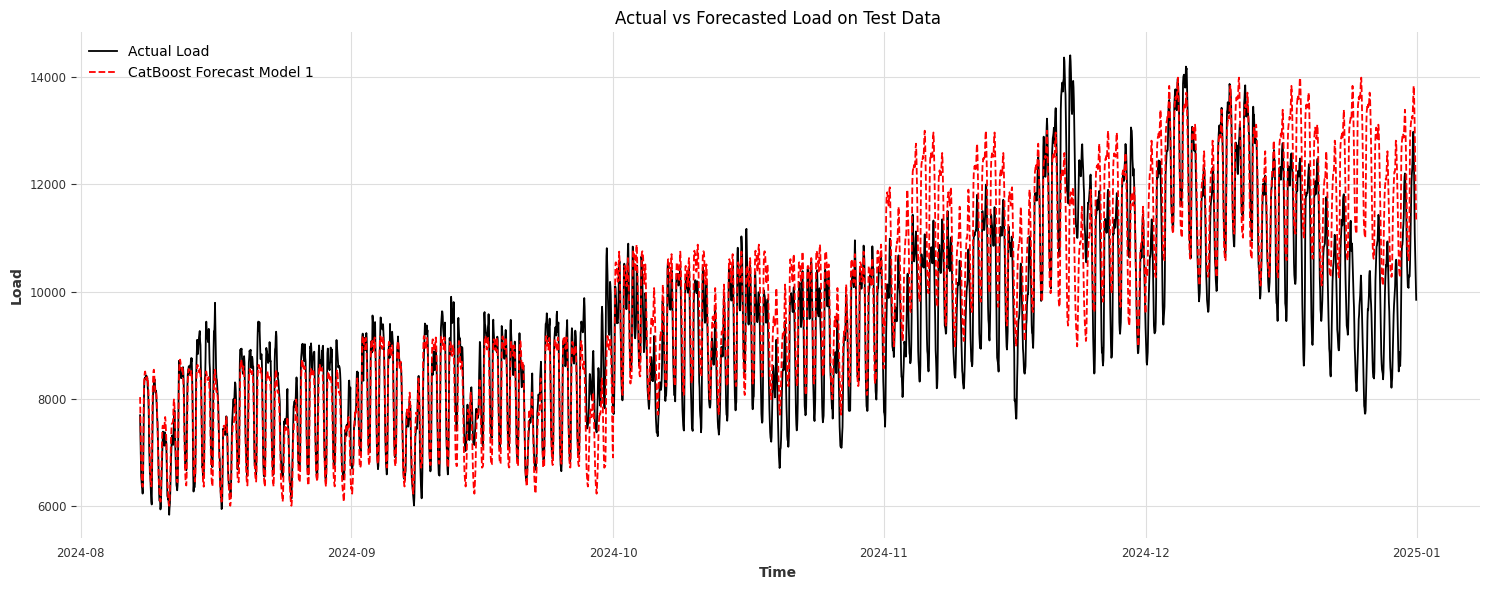

In [6]:
# --- Plot Results ---
plt.figure(figsize=(15,6))
plt.plot(y1_test.index, y1_test, label='Actual Load', color='black')
plt.plot(y1_test.index, y1_pred, label='CatBoost Forecast Model 1', color= 'red', linestyle='--')
plt.title('Actual vs Forecasted Load on Test Data')
plt.xlabel('Time')
plt.ylabel('Load')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Model 2

In [ ]:
# --- Train CatBoost ---
param_grid = {'depth': [4, 6, 8],
              'learning_rate': [0.01, 0.1, 0.5],
              'iterations': [500, 1000, 1500]
              }

# Use MAE as the scoring metric
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)  # Must be negative for GridSearchCV

# Run GridSearchCV
cat_model2 = GridSearchCV(
    CatBoostRegressor(silent=True),
    param_grid,
    scoring=mae_scorer,
    cv=5,  # 5-fold cross-validation
    verbose=10,

)
cat_model2.fit(X2_train, y2_train)

# Best model
best_model2 = cat_model2.best_estimator_
print("Best Parameters:", cat_model2.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters: {'depth': 6, 'iterations': 1000, 'learning_rate': 0.05}


In [8]:
# Predict on test set
y2_pred = best_model2.predict(X2_test)

# Evaluate both MAE and MAPE
mae_cat2 = mean_absolute_error(y2_test, y2_pred)
mape_cat2 = mean_absolute_percentage_error(y2_test, y2_pred)
mse_cat2 = mean_squared_error(y2_test, y2_pred)
rmse_cat2 = np.sqrt(mse_cat2)
print(f"Lowest MAE: {mae_cat2:.2f}")
print(f"Corresponding MAPE: {mape_cat2:.4f}")
print(f"Corresponding RMSE: {rmse_cat2:.4f}")

Lowest MAE: 368.52
Corresponding MAPE: 0.0389
Corresponding RMSE: 507.6073


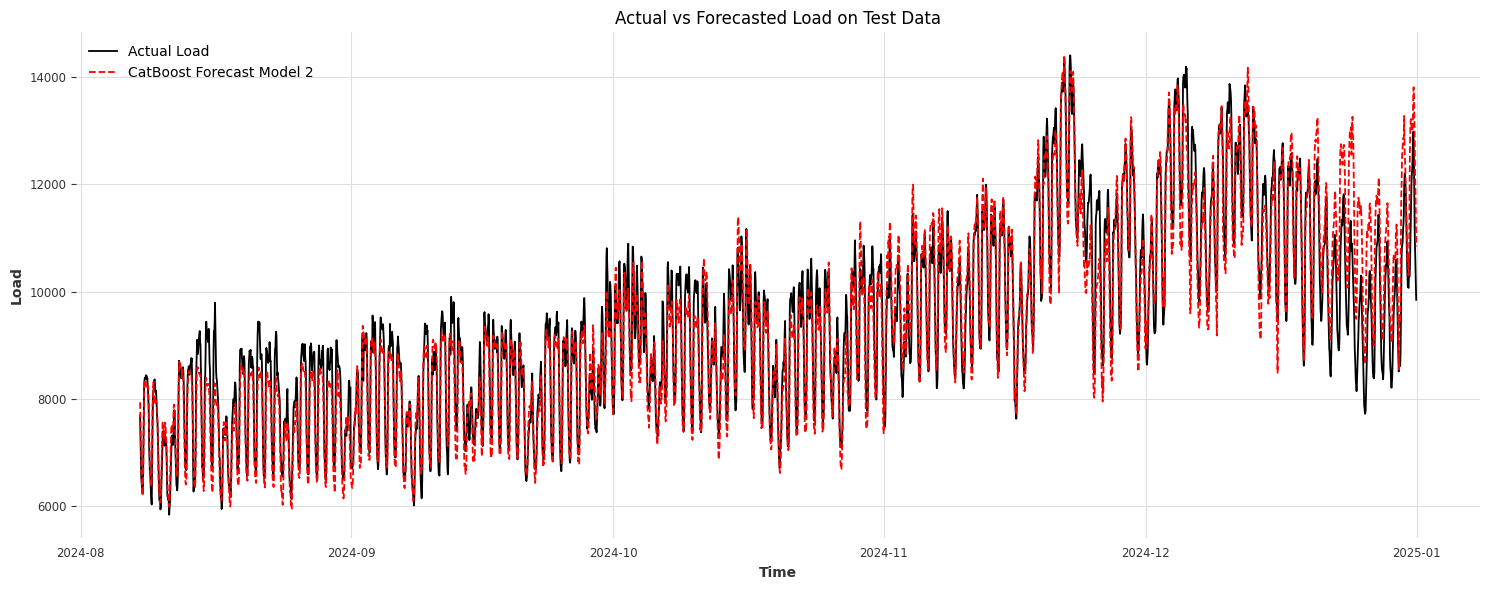

In [9]:
# --- Plot Results ---
plt.figure(figsize=(15,6))
plt.plot(y2_test.index, y2_test, label='Actual Load', color='black')
plt.plot(y2_test.index, y2_pred, label='CatBoost Forecast Model 2', color= 'red', linestyle='--')
plt.title('Actual vs Forecasted Load on Test Data')
plt.xlabel('Time')
plt.ylabel('Load')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Model 3

In [ ]:
# --- Train CatBoost ---
param_grid = {'depth': [4, 6, 8],
              'learning_rate': [0.01, 0.1, 0.5],
              'iterations': [500, 1000, 1500]
              }

# Use MAE as the scoring metric
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)  # Must be negative for GridSearchCV

# Run GridSearchCV
cat_model3 = GridSearchCV(
    CatBoostRegressor(silent=True),
    param_grid,
    scoring=mae_scorer,
    cv=5,  # 5-fold cross-validation
    verbose=10,

)
cat_model3.fit(X3_train, y3_train)

# Best model
best_model3 = cat_model3.best_estimator_
print("Best Parameters:", cat_model3.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters: {'depth': 5, 'iterations': 500, 'learning_rate': 0.1}


In [11]:
# Predict on test set
y3_pred = best_model3.predict(X3_test)

# Evaluate both MAE and MAPE
mae_cat3 = mean_absolute_error(y3_test, y3_pred)
mape_cat3 = mean_absolute_percentage_error(y3_test, y3_pred)
mse_cat3 = mean_squared_error(y3_test, y3_pred)
rmse_cat3 = np.sqrt(mse_cat3)
print(f"Lowest MAE: {mae_cat3:.2f}")
print(f"Corresponding MAPE: {mape_cat3:.4f}")
print(f"Corresponding RMSE: {rmse_cat3:.4f}")

Lowest MAE: 335.22
Corresponding MAPE: 0.0355
Corresponding RMSE: 435.3541


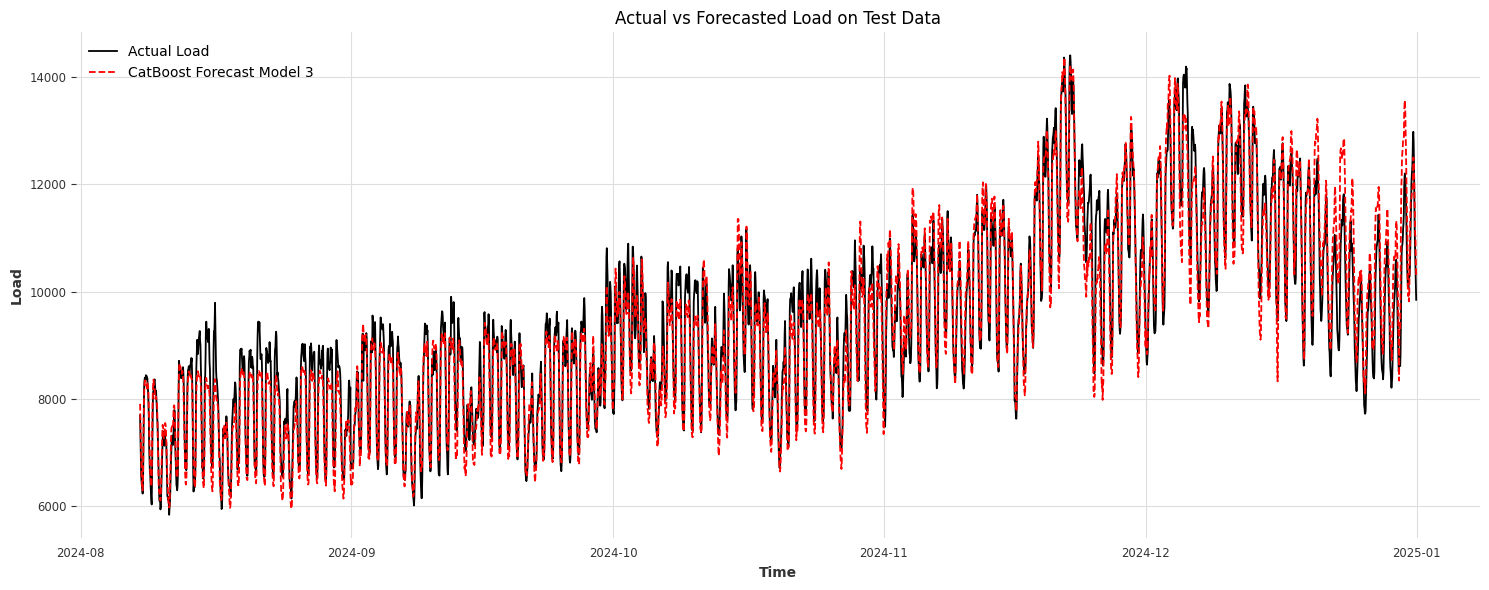

In [13]:
# --- Plot Results ---
plt.figure(figsize=(15,6))
plt.plot(y3_test.index, y3_test, label='Actual Load', color='black')
plt.plot(y3_test.index, y3_pred, label='CatBoost Forecast Model 3', color= 'red', linestyle='--')
plt.title('Actual vs Forecasted Load on Test Data')
plt.xlabel('Time')
plt.ylabel('Load')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Model 4

In [ ]:
# --- Train CatBoost ---
param_grid = {'depth': [4, 6, 8],
              'learning_rate': [0.01, 0.1, 0.5],
              'iterations': [500, 1000, 1500]
              }

# Use MAE as the scoring metric
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)  # Must be negative for GridSearchCV

# Run GridSearchCV
cat_model4 = GridSearchCV(
    CatBoostRegressor(silent=True),
    param_grid,
    scoring=mae_scorer,
    cv=5,  # 5-fold cross-validation
    verbose=10,

)
cat_model4.fit(X4_train, y4_train)

# Best model
best_model4 = cat_model4.best_estimator_
print("Best Parameters:", cat_model4.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters: {'depth': 5, 'iterations': 500, 'learning_rate': 0.1}


In [18]:
# Predict on test set
y4_pred = best_model4.predict(X4_test)

# Evaluate both MAE and MAPE
mae_cat4 = mean_absolute_error(y4_test, y4_pred)
mape_cat4 = mean_absolute_percentage_error(y4_test, y4_pred)
mse_cat4 = mean_squared_error(y4_test, y4_pred)
rmse_cat4 = np.sqrt(mse_cat4)
print(f"Lowest MAE: {mae_cat4:.2f}")
print(f"Corresponding MAPE: {mape_cat4:.4f}")
print(f"Corresponding RMSE: {rmse_cat4:.4f}")

Lowest MAE: 347.36
Corresponding MAPE: 0.0369
Corresponding RMSE: 447.4958


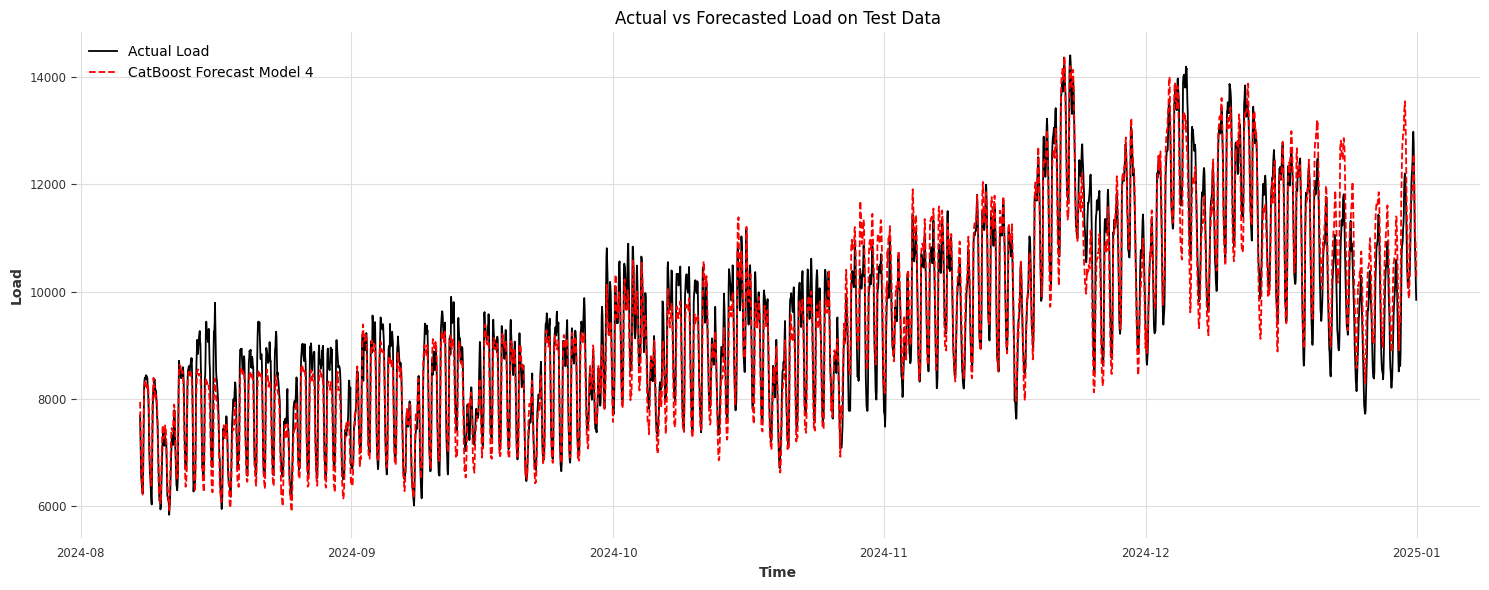

In [19]:
# --- Plot Results ---
plt.figure(figsize=(15,6))
plt.plot(y4_test.index, y4_test, label='Actual Load', color='black')
plt.plot(y4_test.index, y4_pred, label='CatBoost Forecast Model 4', color= 'red', linestyle='--')
plt.title('Actual vs Forecasted Load on Test Data')
plt.xlabel('Time')
plt.ylabel('Load')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

evaluation

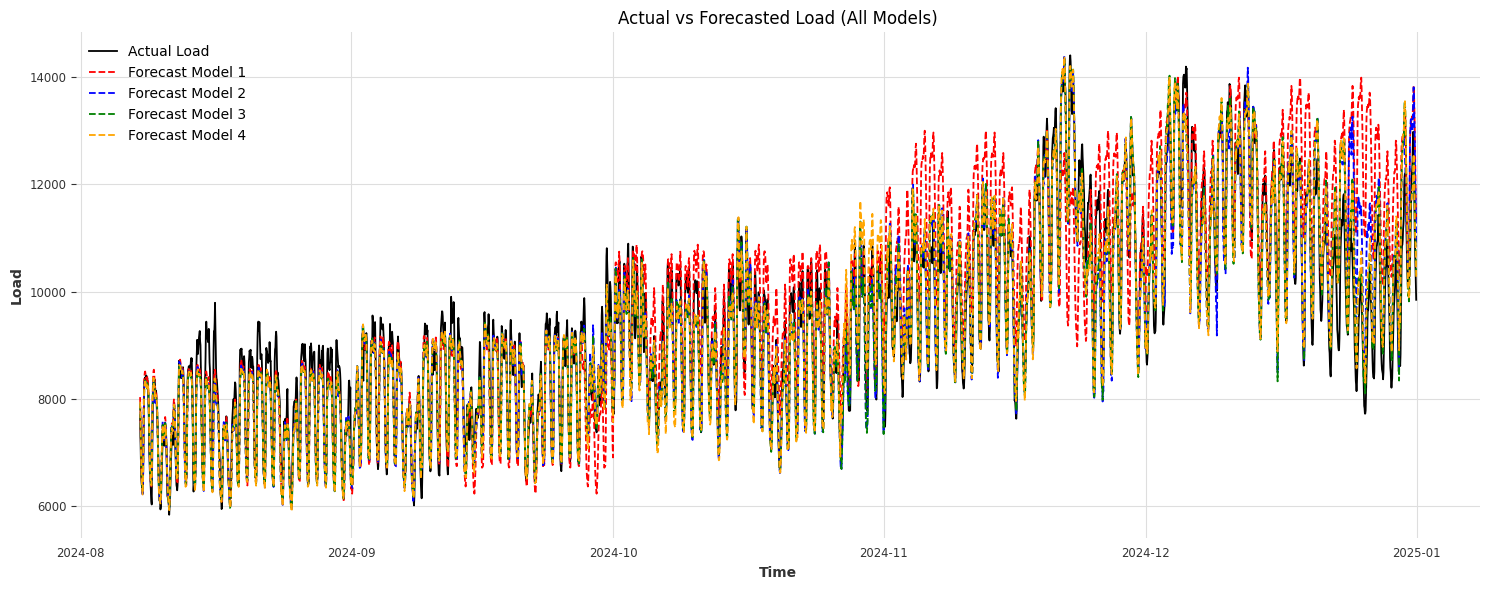

In [36]:
plt.figure(figsize=(15, 6))

# Plot actual load
plt.plot(y1_test.index, y1_test, label='Actual Load', color='black')

# Plot forecasts from each model
plt.plot(y1_test.index, y1_pred, label='Forecast Model 1', linestyle='--', color='red')
plt.plot(y1_test.index, y2_pred, label='Forecast Model 2', linestyle='--', color='blue')
plt.plot(y1_test.index, y3_pred, label='Forecast Model 3', linestyle='--', color='green')
plt.plot(y1_test.index, y4_pred, label='Forecast Model 4', linestyle='--', color='orange')

plt.title('Actual vs Forecasted Load (All Models)')
plt.xlabel('Time')
plt.ylabel('Load')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


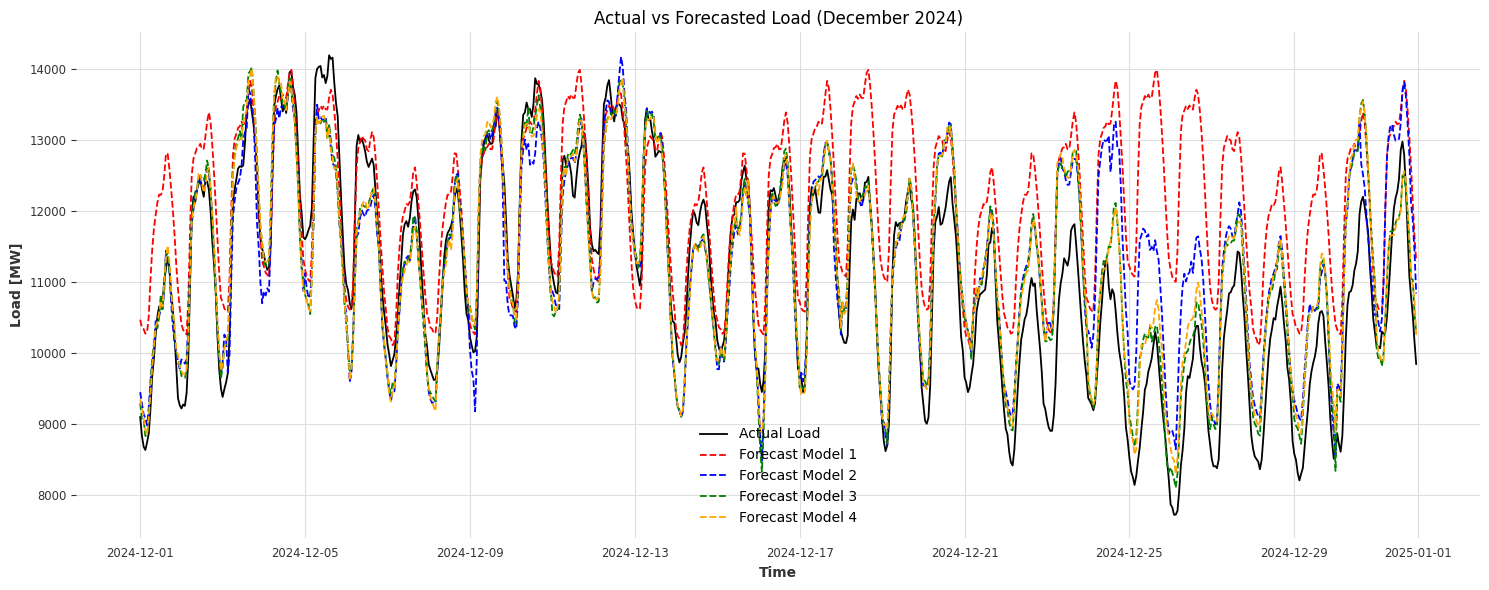

In [38]:
# Make sure y1_test has a datetime index
y1_test.index = pd.to_datetime(y1_test.index)

# Also align predictions to that index
y1_pred = pd.Series(y1_pred, index=y1_test.index)
y2_pred = pd.Series(y2_pred, index=y1_test.index)
y3_pred = pd.Series(y3_pred, index=y1_test.index)
y4_pred = pd.Series(y4_pred, index=y1_test.index)

# Define the time window
start = '2024-12-01 00:00:00'
end = '2024-12-31 23:00:00'

# Slice using full datetime resolution
y1_test_june = y1_test[start:end]
y1_pred_june = y1_pred[start:end]
y2_pred_june = y2_pred[start:end]
y3_pred_june = y3_pred[start:end]
y4_pred_june = y4_pred[start:end]

plt.figure(figsize=(15, 6))
plt.plot(y1_test_june.index, y1_test_june, label='Actual Load', color='black')
plt.plot(y1_pred_june.index, y1_pred_june, label='Forecast Model 1', linestyle='--', color='red')
plt.plot(y2_pred_june.index, y2_pred_june, label='Forecast Model 2', linestyle='--', color='blue')
plt.plot(y3_pred_june.index, y3_pred_june, label='Forecast Model 3', linestyle='--', color='green')
plt.plot(y4_pred_june.index, y4_pred_june, label='Forecast Model 4', linestyle='--', color='orange')

plt.title('Actual vs Forecasted Load (December 2024)')
plt.xlabel('Time')
plt.ylabel('Load [MW]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Test using RNN-LSTM Model

Scaling the data first

In [20]:
from darts.models import RNNModel
from darts.dataprocessing.transformers import Scaler

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
load_train_transformed = transformer.fit_transform(load_train)
load_test_transformed = transformer.transform(load_test)
Load_transformed = transformer.transform(Load)

#### 1st model use the model with normal covariates (month, day of week,hour of day)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 8.3 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
8.3 K     Trainable params
0         Non-trainable params
8.3 K     Total params
0.033     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Backtest MAPE = 6.860067591342467
Backtest MAE = 703.2408650192895
Backtest RMSE = 870.9135358547051


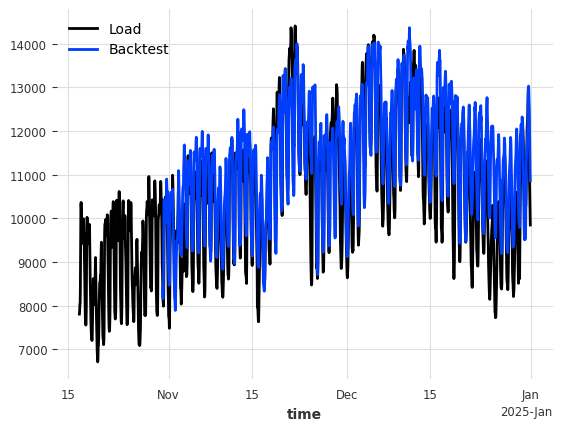

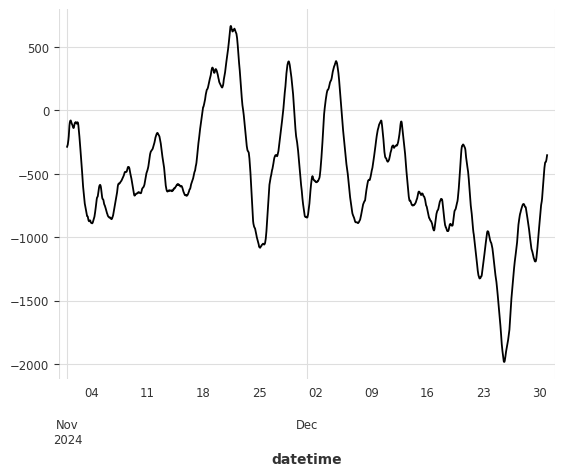

In [24]:
covariates1= TimeSeries.from_dataframe(load_df, time_col="datetime",value_cols=['Month','Day_of_week', 'Hour_of_day'])
rnn_model1 = RNNModel(model= 'LSTM',
                    input_chunk_length=72, 
                    training_length=96, 
                    n_rnn_layers=2)

rnn_model1.fit(load_train_transformed, 
             future_covariates=covariates1,
             epochs=100, 
             verbose=True)

eval_model_transform(rnn_model1,to_retrain=False)    

#### 2nd model  adding temprature covariates normal covariates 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 8.4 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
8.4 K     Trainable params
0         Non-trainable params
8.4 K     Total params
0.034     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Backtest MAPE = 4.211209758203681
Backtest MAE = 463.8020034688302
Backtest RMSE = 601.7165565069076


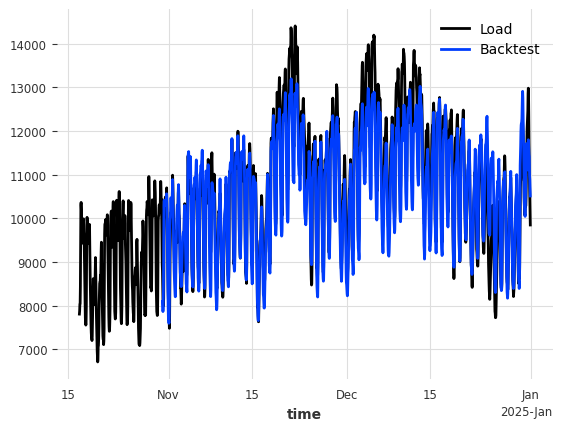

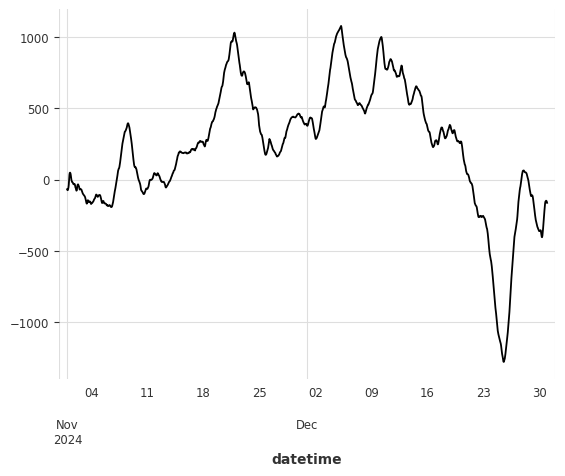

In [25]:
covariates2= TimeSeries.from_dataframe(load_df, time_col="datetime",value_cols=['Temperature','Month','Day_of_week', 'Hour_of_day'])
rnn_model2 = RNNModel(model= 'LSTM',
                    input_chunk_length=72, 
                    training_length=96, 
                    n_rnn_layers=2)

rnn_model2.fit(load_train_transformed, 
             future_covariates=covariates2,
             epochs=100, 
             verbose=True)

eval_model_transform(rnn_model2,to_retrain=False)

#### 3rd model  adding holiday covariates to the 2nd model 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 8.5 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
8.5 K     Trainable params
0         Non-trainable params
8.5 K     Total params
0.034     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Backtest MAPE = 3.24153128928644
Backtest MAE = 349.82797666281374
Backtest RMSE = 462.9284511176089


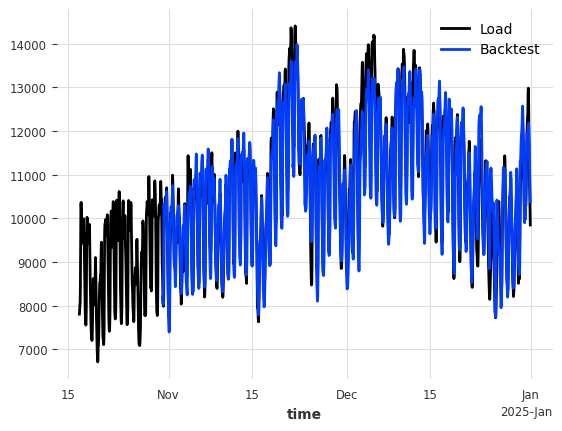

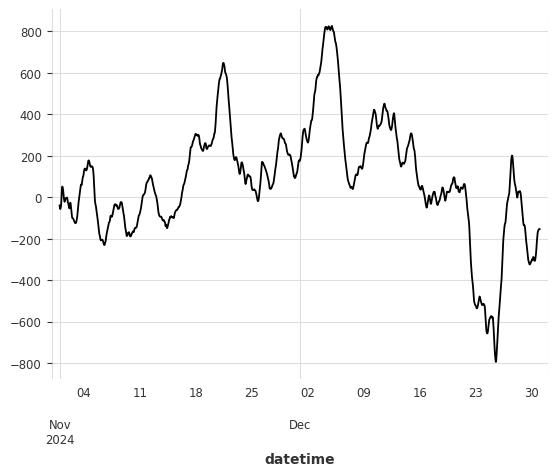

In [28]:
covariates3= TimeSeries.from_dataframe(load_df, time_col="datetime",value_cols=['Temperature','Month','Day_of_week', 'Hour_of_day','Holidays'])
rnn_model3 = RNNModel(model= 'LSTM',
                    input_chunk_length=72, 
                    training_length=96, 
                    n_rnn_layers=2)

rnn_model3.fit(load_train_transformed, 
             future_covariates=covariates3,
             epochs=100, 
             verbose=True)

eval_model_transform(rnn_model3,to_retrain=False)

#### 4th model  adding DST covariates to the 3rd model 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 8.6 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
8.6 K     Trainable params
0         Non-trainable params
8.6 K     Total params
0.035     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Backtest MAPE = 3.1122315877974382
Backtest MAE = 302.0852400895855
Backtest RMSE = 387.4353807679797


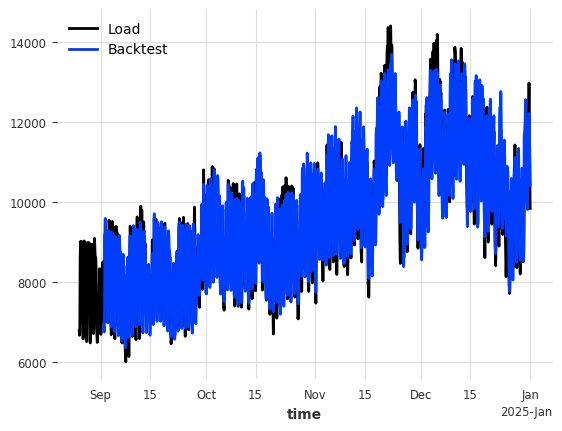

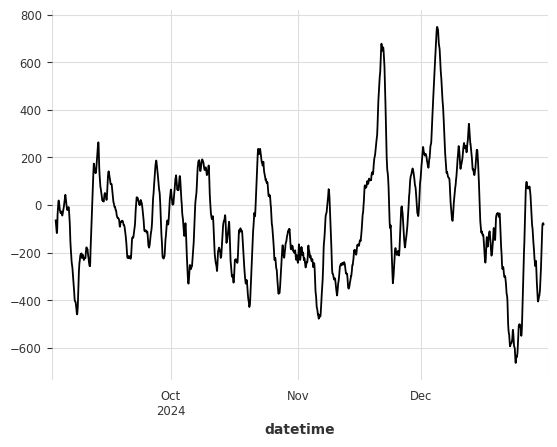

In [37]:
covariates4= TimeSeries.from_dataframe(load_df, time_col="datetime",value_cols=['Temperature','Month','Day_of_week', 'Hour_of_day','Holidays','DST'])
rnn_model4 = RNNModel(model= 'LSTM',
                    input_chunk_length=72, 
                    training_length=96, 
                    n_rnn_layers=2)

rnn_model4.fit(load_train_transformed, 
             future_covariates=covariates4,
             epochs=100, 
             verbose=True)

eval_model_transform(rnn_model4,to_retrain=False)

## Evaluation for RNN

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Backtest MAPE = 5.340637601969995
Backtest MAE = 515.7400692850858
Backtest RMSE = 685.0811670153557


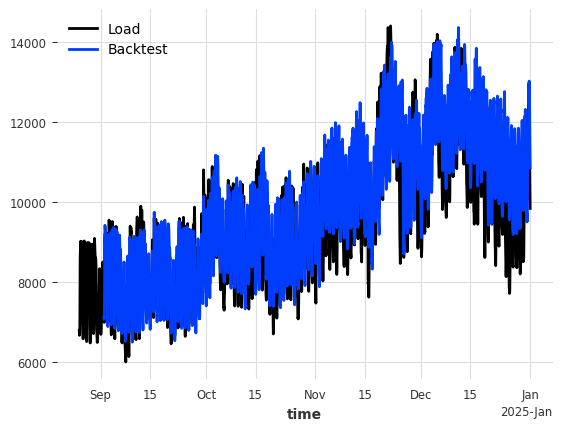

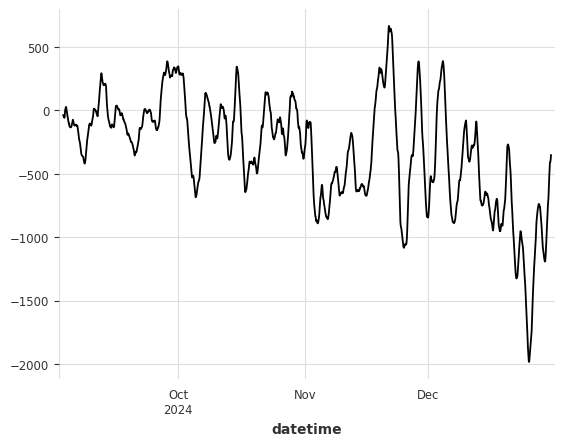

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Backtest MAPE = 3.791049955301191
Backtest MAE = 376.3664887451176
Backtest RMSE = 499.9363441576163


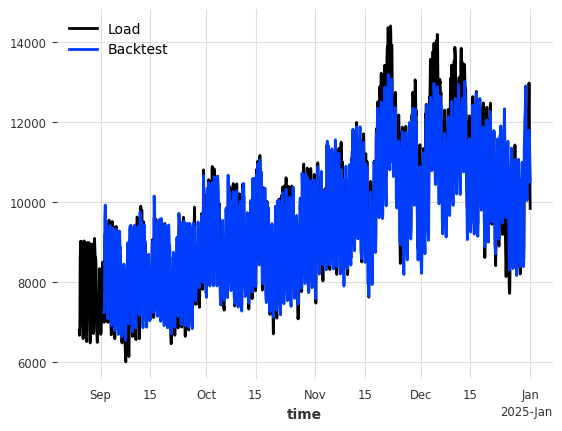

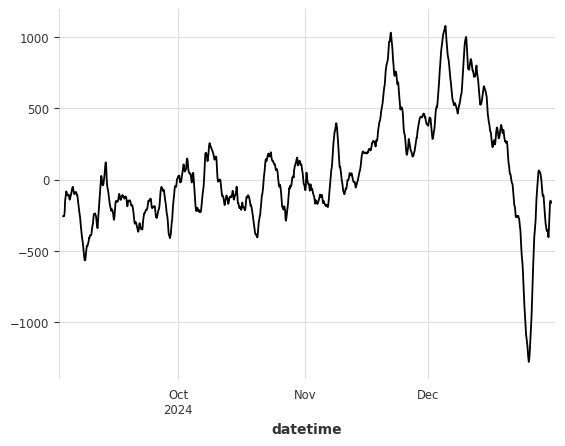

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Backtest MAPE = 3.0911815596932666
Backtest MAE = 303.8917245635524
Backtest RMSE = 403.7168500058635


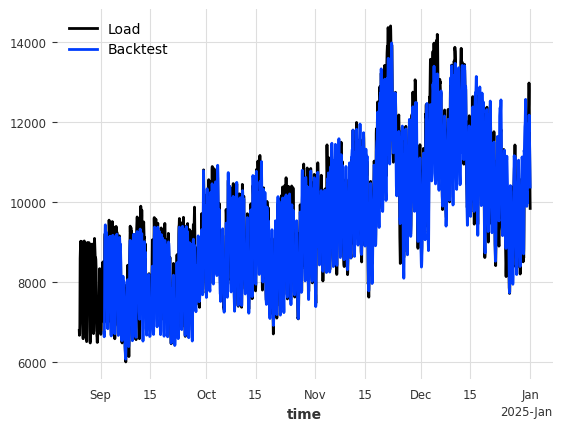

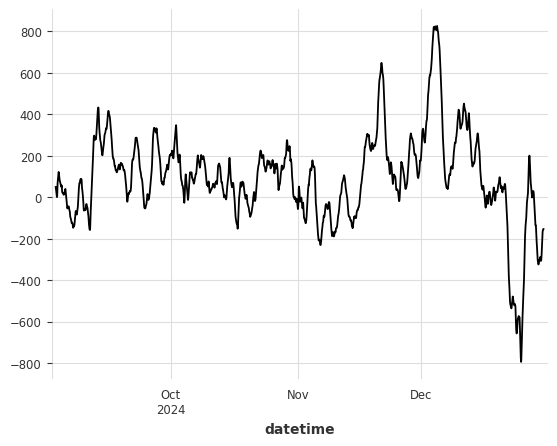

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Backtest MAPE = 3.1122315877974382
Backtest MAE = 302.0852400895855
Backtest RMSE = 387.4353807679797


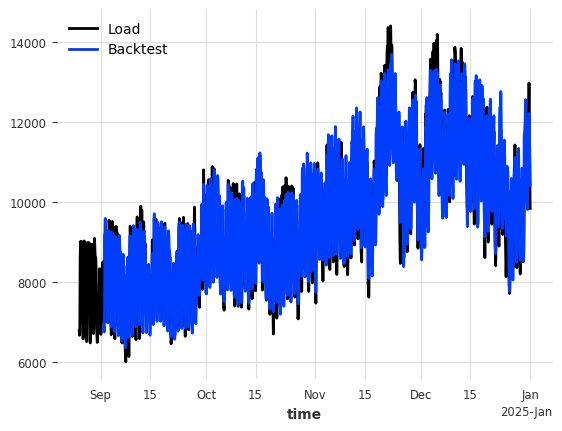

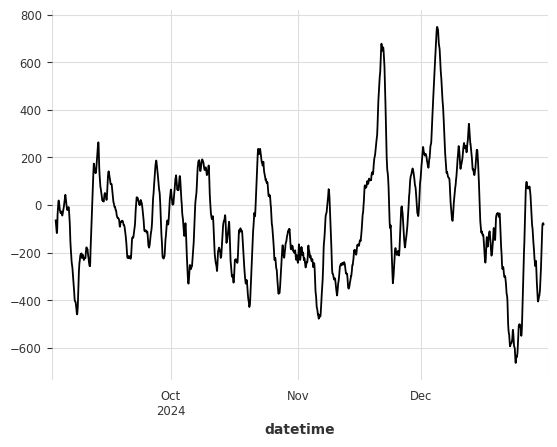

In [42]:
eval_model_transform(rnn_model1,to_retrain=False) 
eval_model_transform(rnn_model2,to_retrain=False) 
eval_model_transform(rnn_model3,to_retrain=False) 
eval_model_transform(rnn_model4,to_retrain=False) 